# Introduction

This notebook showcases the work I have done on adapting the Diffusion Transformer for LiDAR Object generation.

The task we are working on here is to create new views of objects from a LiDAR autonomous driving dataset.

First we need to prep the dataset. 

I used the Nuscenes Devkit to extract all annotations from the training and validation sets. For each annotation I record information on the bounding box and position of the points relative to the LiDAR sensor, as well as the class. This will be used to condition the model.

## The Model
The model is a variant of the classic Diffusion Transformer, with inspiration taken from the Dit3D paper as well as Pixart. 

Many variants and ablations of the model architecture have been tested. Some parameters that I am experimenting are:
- How to embed the points in order to compute attention: Voxel or Pointnet embeddings?
    - Voxelization can reduce the computation, but Pointnet directly encodes spatial information
- How to apply the conditioning: cross attention? Adaptive LayerNorm? Pixart's variation of Adaptive Layer Norm?
- How to handle point clouds of varying size?
- How to encode the conditioning information given that we have some scalar values, and some angular values?

In this example we will work with the best performing model.

This model uses cross attention layers to apply the conditioning information and Pointnet embeddings on our input coordinates.

We pre-process each example by aligning all objects to a canonical axis and centering the points at 0,0,0. We then transform the center coordinate of our object from Cartesian to Cylindrical coordinate space. Finally we combine all of our angular values into the first value of our cylindrical coordinate, and use cyclical embeddings on this value.

By conditioning on the relative position of our object to the LiDAR camera, the model learns to "paint" the LiDAR pattern on the correct face of the object relative to the scanner.

In [3]:
import os
from pytorch_lightning import LightningDataModule
import yaml
import torch
import numpy as np
import open3d as o3d
from tqdm import tqdm
from diffusers import DPMSolverMultistepScheduler
from models.models_dit3d_dropout import DiT3D_Diffuser
from modules.metrics import ChamferDistance, EMD
from modules.three_d_helpers import build_two_point_clouds, cylindrical_to_cartesian, angle_add
from datasets import dataset_mapper
from modules.class_mapping import class_mapping

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Triton is not available, some optimizations will not be enabled.
This is just a warning: triton is not available
Either FairScale or torch distributed is not available, MixtureOfExperts will not be exposed. Please install them if you would like to use MoE


# The Example

In this sample we are going to generate 5 views of the 14th largest bike in the dataset, specifically this example:

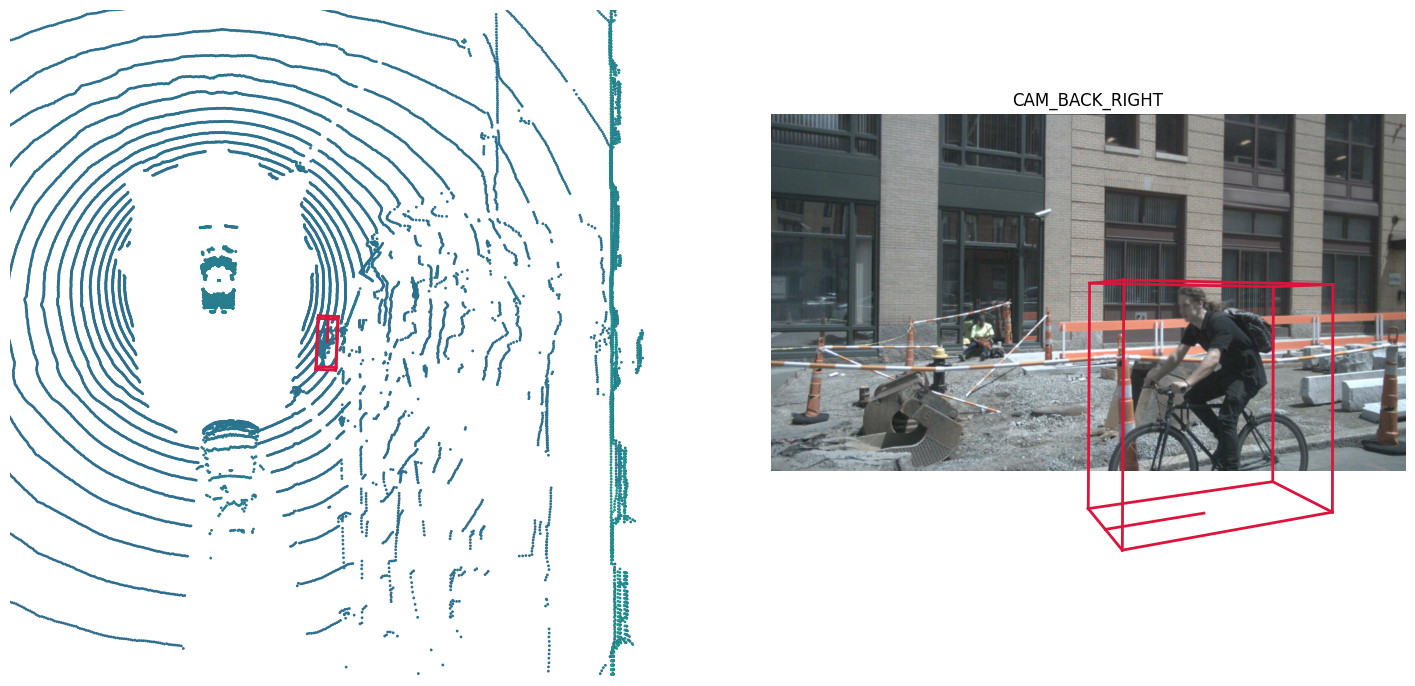

In [1]:
def find_eligible_objects(dataloader, num_to_find=1, object_class='vehicle.car', min_points=None):
    targets = []

    for index, item in enumerate(dataloader):
        num_lidar_points = item['num_points'][0]
        item['index'] = index
        class_index = item['class'].item()

        if object_class != 'None' and class_mapping[object_class] != class_index:
            continue

        if num_lidar_points > min_points:
            targets.append(item)
        
        if len(targets) >= num_to_find:
            break

    return targets

def find_specific_objects(index, cfg):
    # This is a dataset created to find specific bikes that we can compare across models
    cfg['data']['data_dir'] = '/home/ekirby/scania/ekirby/datasets/bikes_from_nuscenes/bikes_from_nuscenes_train_val_reversed.json'
    module: LightningDataModule = dataset_mapper.dataloaders[cfg['data']['dataloader']](cfg)
    dataloader = module.train_dataloader(shuffle=False)
    objects = []
    for i, item in enumerate(dataloader):
        if i == index:
            item['index'] = index
            objects.append(item)
            break

    return objects

In [5]:
def p_sample_loop(model: DiT3D_Diffuser, x_t, x_cond, x_class):
    model.dpm_scheduler = DPMSolverMultistepScheduler(
        num_train_timesteps=model.t_steps,
        beta_start=model.hparams['diff']['beta_start'],
        beta_end=model.hparams['diff']['beta_end'],
        beta_schedule='linear',
        algorithm_type='sde-dpmsolver++',
        solver_order=2,
    )
    model.dpm_scheduler.set_timesteps(model.s_steps)
    model.scheduler_to_cuda()

    for t in tqdm(range(len(model.dpm_scheduler.timesteps))):
        t = model.dpm_scheduler.timesteps[t].cuda()[None]

        with torch.no_grad():
            noise_t = model.classfree_forward(x_t, t, x_class, x_cond)
        input_noise = x_t

        x_t = model.dpm_scheduler.step(noise_t, t, input_noise)['prev_sample']

    return x_t

In [6]:
'''
This function is used to remap our objects into the corresponding position in the original scan
'''
def realign_pointclouds_to_scan(x_gen, orientation, center, aligned_angle):
    cos_yaw = np.cos(orientation)
    sin_yaw = np.sin(orientation)
    rotation_matrix = np.array([
        [cos_yaw, -sin_yaw, 0],
        [sin_yaw, cos_yaw, 0],
        [0, 0, 1]
    ])
    x_gen[:, :3] = np.dot(x_gen[:, :3], rotation_matrix.T)
    new_center = center.copy()
    new_center[0] = angle_add(aligned_angle, orientation)
    new_center = cylindrical_to_cartesian(new_center[None, :]).squeeze(0)
    x_gen[:, :3] += new_center
    x_gen[:, 3] = (x_gen[:, 3] + 1) * 15.  # rescale intensity to 0-30
    return x_gen

In [7]:
def denoise_object_from_pcd(model: DiT3D_Diffuser, x_object, x_center, x_size, x_orientation, x_class):
    torch.backends.cudnn.deterministic = True

    x_init = x_object.clone().cuda()    
    
    # Note that in the data processing, we combine the relative angles of the object into a single value
    x_cond = torch.cat((x_center, x_size),-1)
    x_cond = x_cond.cuda()
    x_class = x_class.cuda()


    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    x_feats = torch.randn(x_init.shape, device=model.device)
    x_gen_eval = p_sample_loop(model, x_feats, x_cond, x_class).squeeze(0).permute(1,0)
    x_gen_pts = x_gen_eval[:, :3]

    x_gen_pts= x_gen_pts.cpu().detach().numpy()
    x_gen_pts = realign_pointclouds_to_scan(x_gen_pts, x_orientation.item(), x_center, x_center[0])

    return x_gen_pts

In [8]:
def extract_object_info(object_info):
    x_object = object_info['pcd_object']
    x_center = object_info['center']
    x_size = object_info['size']
    x_orientation = object_info['orientation']
    x_class = object_info['class']

    return x_object, x_center, x_size, x_orientation, x_class

def generate_interpolated_conditions(dir_path, conditions, model, objects):
    for object_info in objects:
        pcd, center_cyl, size, yaw, x_class = extract_object_info(object_info)
        
        og_pcd = pcd.cpu().detach().squeeze(0).permute(1,0).numpy()[:, :3]
        og_pcd = realign_pointclouds_to_scan(og_pcd, yaw, center_cyl, center_cyl[0])
        np.savetxt(f'{dir_path}/object_{object_info["index"]}_orig.txt', og_pcd)

        def do_gen(condition, index, center_cyl=center_cyl, size=size, yaw=yaw, pcd=pcd):
                x_gen = denoise_object_from_pcd(
                    model=model,
                    x_object=pcd,
                    x_center=center_cyl,
                    x_size=size, 
                    x_orientation=yaw,
                    x_class=x_class,
                )
                np.savetxt(f'{dir_path}/object_{object_info["index"]}_{condition}_interp_{index}.txt', x_gen)

        for condition in conditions:
            if condition == 'yaw':
                orig = yaw
                angles = np.linspace(start=orig, stop=orig*-1, num=5)
                print(f'Interpolating Yaw')
                for index, angle in enumerate(angles):
                    do_gen(condition, index=index, yaw=torch.from_numpy(angle))
            if condition == 'cylinder_angle':
                print(f'Interpolating Cylindrical Angle')
                start = center_cyl[:, 0]
                linspace_ring = np.linspace(start=start, stop=start + 2 * np.pi, num=5, endpoint=False)
                linspace_ring = (linspace_ring + np.pi) % (2 * np.pi) - np.pi
                for index, ring in enumerate(linspace_ring):
                    new_cyl = center_cyl.clone()
                    new_cyl[:,0] = ring.item()
                    do_gen(condition, index=index, center_cyl=new_cyl)
            if condition == 'cylinder_distance':
                print(f'Interpolating Cylindrical Distance')
                start = center_cyl[:, 1]
                linspace_dist = np.linspace(start=start, stop=start*4, num=4)
                for index, dist in enumerate(linspace_dist):
                    new_cyl = center_cyl.clone()
                    new_cyl[:,1] = dist.item()
                    orig_total_points = pcd.shape[-1]
                    subsampled_total_points = orig_total_points // (index + 2)
                    random_order = torch.randperm(orig_total_points)
                    new_pcd = pcd.clone()[:, :, random_order]
                    new_pcd = new_pcd[:, :, :subsampled_total_points]
                    do_gen(condition, index=index, center_cyl=new_cyl, pcd=new_pcd)
            

In [ ]:
output_path = 'evaluations/generated_pcds'
name = 'sample_generation'

# The specific model we want to use is described in this config
config = 'config/ablation_3/xs_4_1a_cross_pointnet_impcfg_4ch.yaml'
weights = 'checkpoints/xs_4_1a_cross_pointnet_impcgf_4ch/last.ckpt'

dir_path = f'{output_path}/{name}'
os.makedirs(dir_path, exist_ok=True)
cfg = yaml.safe_load(open(config))
cfg['diff']['s_steps'] = 500
cfg['train']['batch_size'] = 1
model = DiT3D_Diffuser.load_from_checkpoint(weights, hparams=cfg).cuda()
model.eval()

specific_object_index = 14
objects = find_specific_objects(specific_object_index, cfg)

generate_interpolated_conditions(dir_path, ['cylindrical_angle'], model, objects)

# The Result

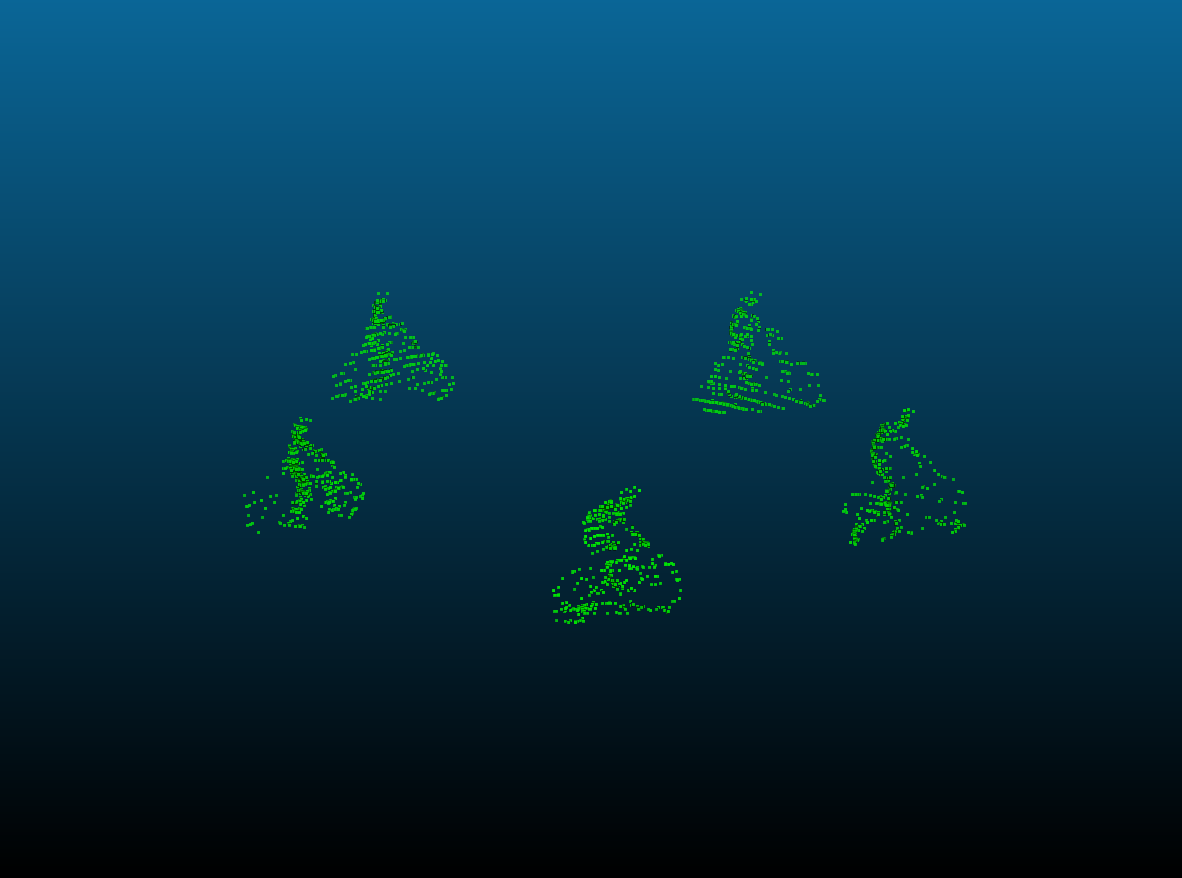

Here we see the result of generating 5 variations of our original bike. Each variation is positioned at a different cylindrical angular position and has the corresponding LiDAR pattern of an object positioned relative to the scanner at that position.

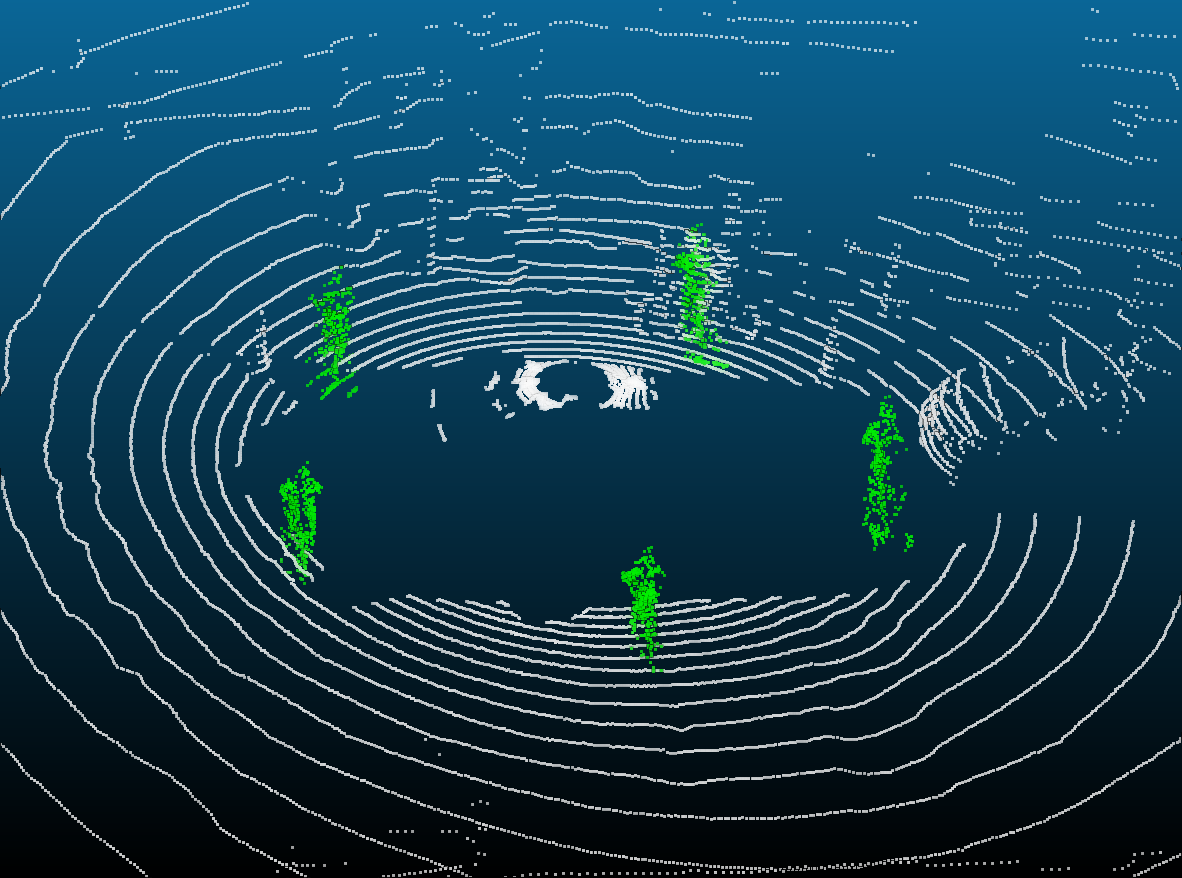

Here we see the objects added back to their original scene.
